In [1]:
!pip install kaggle

In [89]:
# Downgrate numpy to fix a problem
!pip install numpy==1.16.2
import numpy as np
print(np.__version__)

     |████████████████████████████████| 17.3MB 2.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.1
    Uninstalling numpy-1.16.1:
      Successfully uninstalled numpy-1.16.1


1.17.3


In [5]:
!ls -a

.   accuracy_curve.png	input	 logs.npy	 sample_data
..  .config		.kaggle  loss_curve.png


In [6]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"sivaganesh1988","key":"778f842999ef35c2050806923bf27d8d"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)


In [0]:
# may run into problems, see updated version below
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [15]:
!kaggle datasets download -d nih-chest-xrays/sample -p /content/input/

100% 4.19G/4.20G [01:36<00:00, 45.5MB/s]
100% 4.20G/4.20G [01:36<00:00, 46.5MB/s]


In [7]:
!ls /content/input

data  resized-256  sample.zip


In [17]:
!unzip /content/input/sample.zip -d /content/input/data





Archive:  /content/input/sample.zip
  inflating: /content/input/data/sample/images/00000013_005.png  
  inflating: /content/input/data/sample/images/00000013_026.png  
  inflating: /content/input/data/sample/images/00000017_001.png  
  inflating: /content/input/data/sample/images/00000030_001.png  
  inflating: /content/input/data/sample/images/00000032_001.png  
  inflating: /content/input/data/sample/images/00000040_003.png  
  inflating: /content/input/data/sample/images/00000042_002.png  
  inflating: /content/input/data/sample/images/00000057_001.png  
  inflating: /content/input/data/sample/images/00000061_002.png  
  inflating: /content/input/data/sample/images/00000061_019.png  
  inflating: /content/input/data/sample/images/00000061_025.png  
  inflating: /content/input/data/sample/images/00000079_000.png  
  inflating: /content/input/data/sample/images/00000080_005.png  
  inflating: /content/input/data/sample/images/00000083_000.png  
  inflating: /content/input/data/sample/

In [44]:
import pandas as pd
import seaborn as sns
data = pd.read_csv("/content/input/data/sample_labels.csv")
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [0]:
data.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID', 'Patient_Age', 'Patient_Gender',
                'View_Position', 'Original_Image_Width', 'Original_Image_Height', 
                'Original_Image_Pixel_Spacing_X', 'Original_Image_Pixel_Spacing_Y']

In [23]:
data.Finding_Labels.value_counts().head(20)

No Finding                           3044
Infiltration                          503
Effusion                              203
Atelectasis                           192
Nodule                                144
Pneumothorax                          114
Mass                                   99
Consolidation                          72
Effusion|Infiltration                  69
Pleural_Thickening                     65
Atelectasis|Infiltration               57
Atelectasis|Effusion                   55
Cardiomegaly                           50
Infiltration|Nodule                    44
Emphysema                              42
Edema                                  41
Fibrosis                               38
Atelectasis|Effusion|Infiltration      31
Cardiomegaly|Effusion                  30
Infiltration|Mass                      29
Name: Finding_Labels, dtype: int64

In [24]:

data.drop(['Original_Image_Pixel_Spacing_X', 'Original_Image_Pixel_Spacing_Y'], axis = 1, inplace = True)
data.drop(['Original_Image_Width', 'Original_Image_Height'], axis = 1, inplace = True)
data.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP
2,00000017_001.png,No Finding,1,17,077Y,M,AP
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP


In [25]:
total_visits = data.groupby('Patient_ID')['Image_Index'].count().reset_index()
total_visits.sort_values(by="Image_Index", ascending=False).head(10)

,Patient_ID,Image_Index
1449,10007,11
2540,17138,9
1169,8008,9
2020,13670,9
1757,11925,8
703,4858,8
892,6271,7
3887,27726,7
2442,16508,7
1654,11379,7


In [0]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

In [9]:
labels = pd.read_csv('/content/input/data/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


In [10]:
PATH = os.path.abspath(os.path.join('/content/', 'input/data/sample'))
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 4
    Emphysema="Emphysema" #5
    Fibrosis="Fibrosis" #6
    Effusion="Effusion" #7
    Pneumonia="Pneumonia" #8
    Pleural_Thickening="Pleural_Thickening" #9
    Cardiomegaly="Cardiomegaly" #10
    NoduleMass="Nodule" #11
    Hernia="Hernia" #12
    Atelectasis="Atelectasis"  #13
    RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 128
    HEIGHT = 128
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        full_size_image = cv2.imread(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if symbol in finding:
            continue
        else:
            if NoFinding in finding:
                finding = 0
                #y.append(finding)
                #x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Consolidation in finding:
                finding = 1
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Infiltration in finding:
                finding = 2
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumothorax in finding:
                finding = 3
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Edema in finding:
                finding = 4
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Emphysema in finding:
                finding = 5
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Fibrosis in finding:
                finding = 6
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Effusion in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumonia in finding:
                finding = 8
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pleural_Thickening in finding:
                finding = 9
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Cardiomegaly in finding:
                finding = 10
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif NoduleMass in finding:
                finding = 11
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Hernia in finding:
                finding = 12
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Atelectasis in finding:
                finding = 13
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

1483 (128, 128, 3)
<class 'list'>


In [11]:
dict_characters = {1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4:'Edema', 5: 'Emphysema ', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'NoduleMass', 12: 'Hernia', 13: "Atelectasis"}

print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[12, 12, 12], [12, 12, 12], [12, 12, 12], [1...       2
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      13
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       4
3  [[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], ...       2
4  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...       4
5  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...      13
6  [[[19, 19, 19], [0, 0, 0], [0, 0, 0], [0, 0, 0...       2
7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      11
8  [[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], ...       7
9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       9

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema ', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'NoduleMass', 12: 'Hernia', 13: 'Atelectasis'}


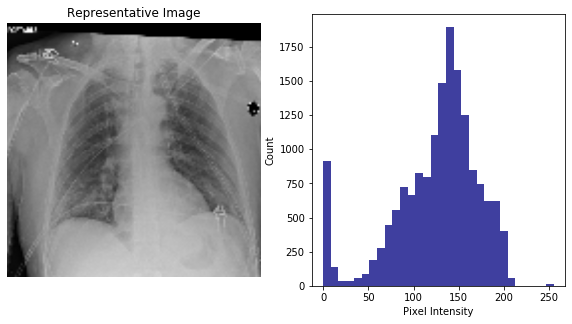

In [12]:
#Describe the distribution of pixel intensities within a representative image
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[1])

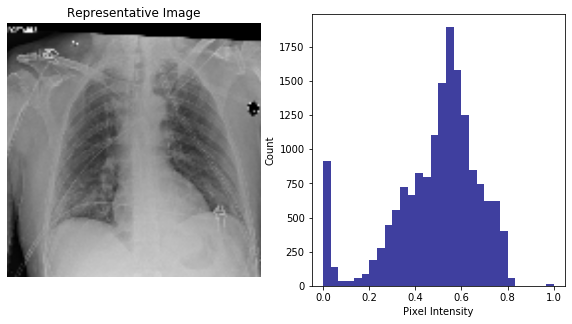

In [13]:
#Normalize the pixel intensities between zero and one.
X=np.array(X)
X=X/255.0
plotHistogram(X[1])

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema ', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'NoduleMass', 12: 'Hernia', 13: 'Atelectasis'}


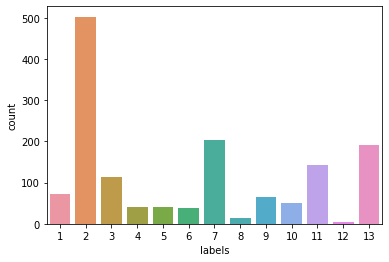

In [14]:
#Describe distribution of class labels
#can see the class is imbalance
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [16]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (1186, 128, 128, 3)
Testing Data Shape: (297, 128, 128, 3)
Training Data Shape: 1186 (128, 128, 3)
Testing Data Shape: 297 (128, 128, 3)


In [0]:
#Now I will try to use a CNN to predict each ailment based off of the X-Ray image.
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 14)
Y_testHot = to_categorical(Y_test, num_classes = 14)

In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes. In this case the class_weights parameter will eventually be passed to the model.fit function.

In [18]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[ 1.58440171  0.22679309  1.00067476  2.78236398  2.71611722  3.00202429
  0.56195529  8.14835165  1.75502959  2.28153846  0.79220085 22.81538462
  0.59415064]


In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')


In [0]:
def runCNNconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (128, 128, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = Adagrad()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()
#runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,6,1)

In [0]:
def runMLPconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (128, 128, 3)

    model = Sequential()
    # hidden layer with 512 neurons, initial layer must be preset as takes inputs as image
    model.add(Dense(units=512, kernel_initializer = 'uniform', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(rate = 0.5)) # can use drop out to improve prediction no change on  dataset
    # hidden layer with 512 neurons each
    ################ comment out if not needed#############
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(rate = 0.5))
    # hidden layer with 512 neurons each
    ################ comment out if not needed#############
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Flatten())
    # hidden layer with 512 neurons each
    ################ comment out if not needed#############
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    #######################################################
    # output layer with 14 neurons
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    '''
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    '''
    # Define the optimizer
    optimizer = Adagrad()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()
runMLPconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,6,1)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128, 128, 512)     2048      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 512)     2048      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 512)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 512)     0         
_________________________________________________________________
dense_2 (Dense)              (None, 128, 128, 512)     262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 512)     2048 

In [0]:
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,6,1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


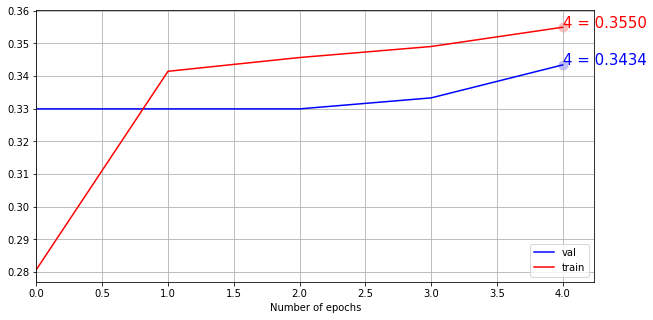

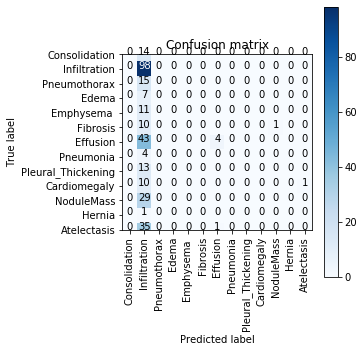

In [29]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
im_size = 128
map_characters=dict_characters
def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        10
      Infiltration       0.32      0.54      0.40        96
      Pneumothorax       0.00      0.00      0.00        21
             Edema       0.00      0.00      0.00         9
        Emphysema        0.00      0.00      0.00         7
          Fibrosis       0.00      0.00      0.00        12
          Effusion       0.25      0.49      0.33        47
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        16
      Cardiomegaly       0.00      0.00      0.00        13
        NoduleMass       0.00      0.00      0.00        24
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.00      0.00      0.00        38

          accuracy                           0.25       297
         macro avg       0.04      0.08      0.06       297
      weighted avg       0.14      0.

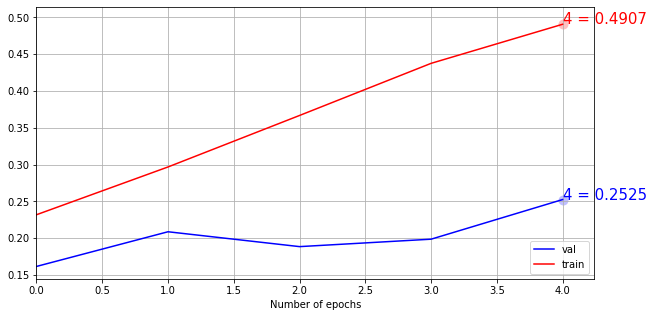

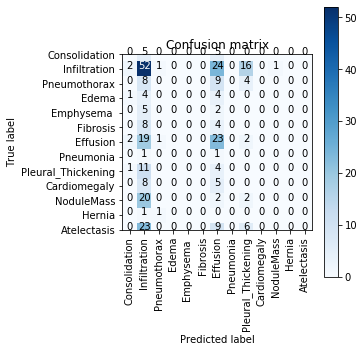

In [34]:

from keras.models import Model
from keras.applications import  densenet, Xception, NASNetMobile
from tensorflow.keras.applications.mobilenet import MobileNet

im_size = 128
map_characters=dict_characters
def densenet121network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a densenet architecture NN'
    base_model = densenet.DenseNet121( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
densenet121network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)

51879936/51877672 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
___________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        10
      Infiltration       0.34      0.88      0.49        96
      Pneumothorax       0.00      0.00      0.00        21
             Edema       0.00      0.00      0.00         9
        Emphysema        0.00      0.00      0.00         7
          Fibrosis       0.00      0.00      0.00        12
          Effusion       0.33      0.02      0.04        47
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        16
      Cardiomegaly       0.00      0.00      0.00        13
        NoduleMass       0.07      0.08      0.08        24
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.50      0.03      0.05        38

          accuracy                           0.30       297
         macro avg       0.10      0.08      0.05       297
      weighted avg       0.23      0.

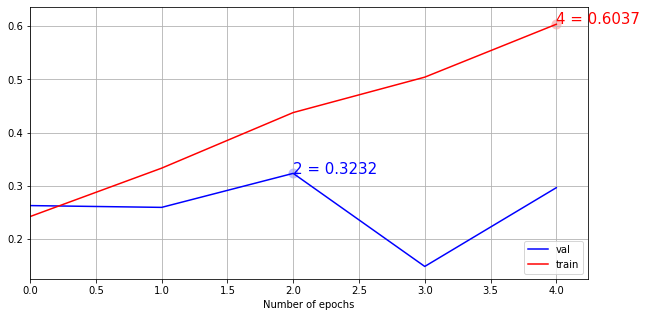

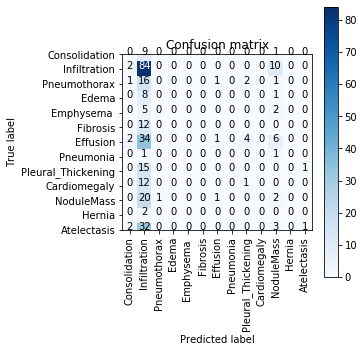

In [36]:

from keras.models import Model
from keras.applications import  densenet, Xception, NASNetMobile
from tensorflow.keras.applications.mobilenet import MobileNet

im_size = 128
map_characters=dict_characters
def densenet169network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a densenet architecture NN'
    base_model = densenet.DenseNet169( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
densenet169network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        10
      Infiltration       0.34      0.98      0.50        96
      Pneumothorax       0.00      0.00      0.00        21
             Edema       0.00      0.00      0.00         9
        Emphysema        0.00      0.00      0.00         7
          Fibrosis       0.00      0.00      0.00        12
          Effusion       0.44      0.17      0.25        47
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        16
      Cardiomegaly       0.00      0.00      0.00        13
        NoduleMass       0.00      0.00      0.00        24
            Hernia       0.00      0.00      0.00         2
       Atelectasis       1.00      0.03      0.05        38

          accuracy                           0.35       297
         macro avg       0.14      0.09      0.06       297
      weighted avg       0.31      0.

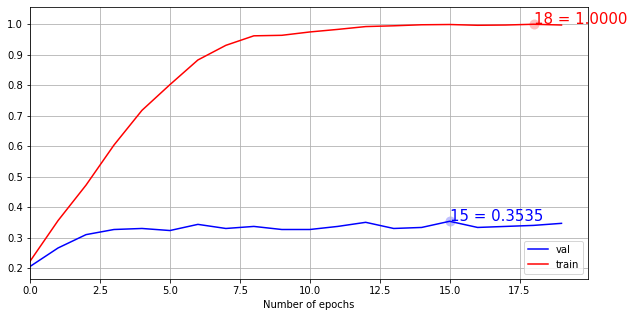

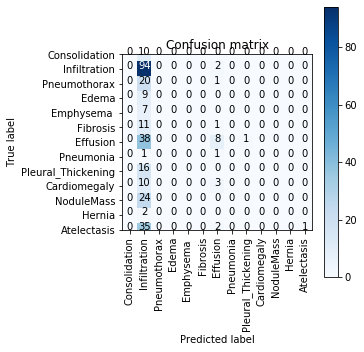

In [41]:

from keras.models import Model
from keras.applications import  densenet, Xception, NASNetMobile
from keras.applications.mobilenet import MobileNet

im_size = 128
map_characters=dict_characters
def mobilenetnetwork(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a MobileNet architecture NN'
    base_model = MobileNet( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
mobilenetnetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,20)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        10
      Infiltration       0.32      0.97      0.48        96
      Pneumothorax       0.00      0.00      0.00        21
             Edema       0.00      0.00      0.00         9
        Emphysema        0.00      0.00      0.00         7
          Fibrosis       0.00      0.00      0.00        12
          Effusion       0.12      0.02      0.04        47
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        16
      Cardiomegaly       0.00      0.00      0.00        13
        NoduleMass       0.00      0.00      0.00        24
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.00      0.00      0.00        38

          accuracy                           0.32       297
         macro avg       0.03      0.08      0.04       297
      weighted avg       0.12      0.

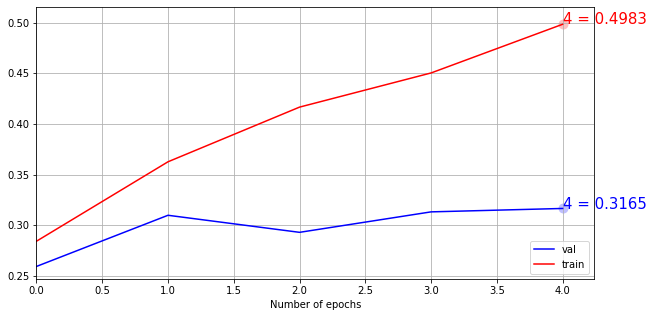

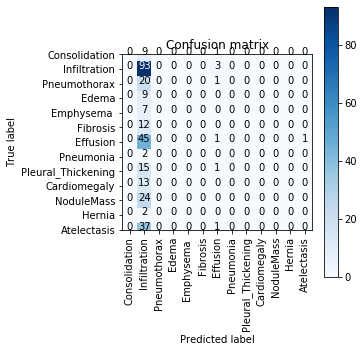

In [45]:

from keras.models import Model
from keras.applications import  densenet, Xception, NASNetMobile


im_size = 128
map_characters=dict_characters
def xceptionnetwork(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a MobileNet architecture NN'
    base_model = Xception( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
xceptionnetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)

87916544/87910968 [==============================] - 7s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 63, 63, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 63, 63, 32)   96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_5[0][0]      
___________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        10
      Infiltration       0.32      0.82      0.46        96
      Pneumothorax       0.00      0.00      0.00        21
             Edema       0.00      0.00      0.00         9
        Emphysema        0.00      0.00      0.00         7
          Fibrosis       0.00      0.00      0.00        12
          Effusion       0.16      0.15      0.15        47
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        16
      Cardiomegaly       0.00      0.00      0.00        13
        NoduleMass       0.33      0.04      0.07        24
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.00      0.00      0.00        38

          accuracy                           0.29       297
         macro avg       0.06      0.08      0.05       297
      weighted avg       0.15      0.

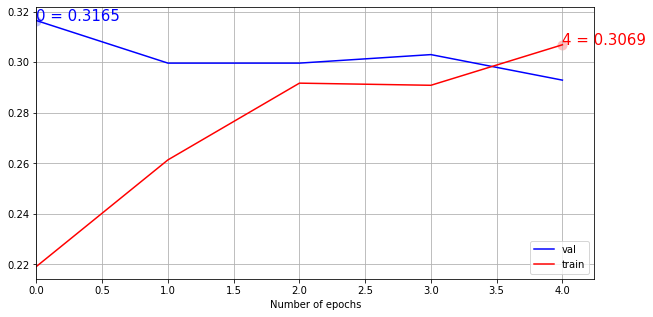

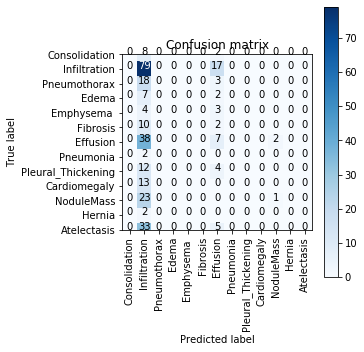

In [49]:

from keras.models import Model
from keras.applications import  densenet, Xception, NASNetMobile
from keras.applications.inception_v3 import InceptionV3

im_size = 128
map_characters=dict_characters
def inceptionV3network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a MobileNet architecture NN'
    base_model = InceptionV3( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
inceptionV3network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

     Consolidation       0.00      0.00      0.00        10
      Infiltration       0.32      1.00      0.49        96
      Pneumothorax       0.00      0.00      0.00        21
             Edema       0.00      0.00      0.00         9
        Emphysema        0.00      0.00      0.00         7
          Fibrosis       0.00      0.00      0.00        12
          Effusion       0.00      0.00      0.00        47
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        16
      Cardiomegaly       0.00      0.00      0.00        13
        NoduleMass       0.00      0.00      0.00        24
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.00      0.00      0.00        38

          accuracy                           0.32       297
         macro avg       0.02      0.08      0.04       297
      weighted avg       0.10      0.

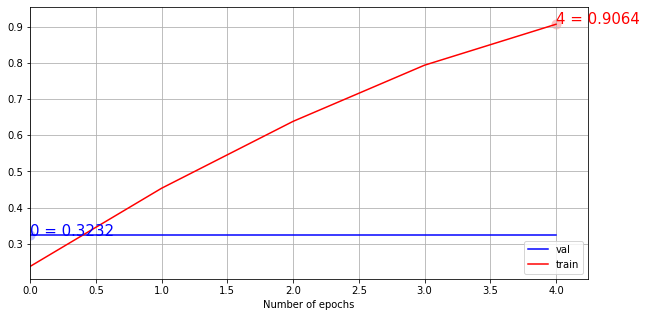

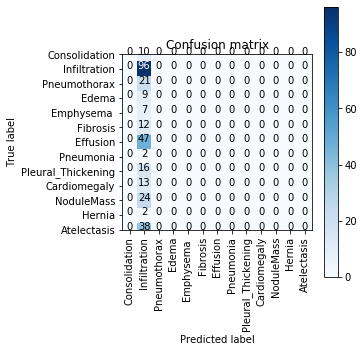

In [50]:

from keras.models import Model
from keras.applications.resnet50 import ResNet50

im_size = 128
map_characters=dict_characters
def resnetnetwork(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a MobileNet architecture NN'
    base_model = ResNet50( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
resnetnetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)

In [0]:

from keras.models import Model
from keras.applications.vgg19 import VGG19

im_size = 128
map_characters=dict_characters
def vgg19network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a MobileNet architecture NN'
    base_model = VGG19( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
#vgg19network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,3)

In [0]:

from keras.models import Model
#from keras.applications import  densenet, Xception, NASNetMobile
from keras.applications import Xception

im_size = 128
map_characters=dict_characters
def xceptionnetwork(a,b,c,d,e,f,g):
    num_class = f
    epochs = g

    'Returns a MobileNet architecture NN'
    base_model = Xception( input_shape=(im_size, im_size, 3), weights='imagenet', include_top=False)
		
		# add classification top layer
    #model = Sequential()
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    '''
    model.add(dense_net_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='sigmoid'))
    '''
    '''
    base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
    
    '''
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
#xceptionnetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,5)


The imbalance in our dataset has resulted in a biased model. I tried to prevent this by modifying the class_weights parameter and using in the model.fit function but apparently that was not enough. Now I will try to compensate for the imbalanced sample size by oversampling or upsampling the minority classes.

{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema ', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'NoduleMass', 12: 'Hernia', 13: 'Atelectasis'}


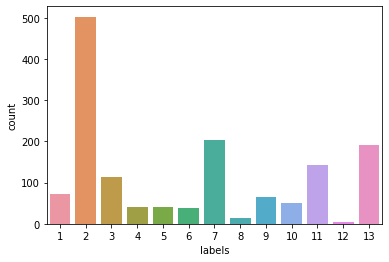

In [52]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

It is very import to do upsampling AFTER the train_test_split function otherwise you can end up with values in the testing dataset that are related to the values within the training dataset.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [54]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (1186, 128, 128, 3)
X_test Shape:  (297, 128, 128, 3)
X_trainFlat Shape:  (1186, 49152)
X_testFlat Shape:  (297, 49152)


In [55]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 14)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 14)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


X_train:  (1186, 128, 128, 3)
X_trainFlat:  (1186, 49152)
X_trainRos Shape:  (5200, 49152)
X_testRos Shape:  (1236, 49152)
Y_trainRosHot Shape:  (5200, 14)
Y_testRosHot Shape:  (1236, 14)


In [56]:
for i in range(len(X_trainRos)):
    height, width, channels = 128,128,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 128,128,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (5200, 49152)
X_trainRosReshaped Shape:  (5200, 128, 128, 3)
X_testRos Shape:  (1236, 49152)
X_testRosReshaped Shape:  (1236, 128, 128, 3)


{1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema ', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'NoduleMass', 12: 'Hernia', 13: 'Atelectasis'}
2     503
7     203
13    192
11    144
3     114
1      72
9      65
10     50
5      42
4      41
6      38
8      14
12      5
Name: labels, dtype: int64


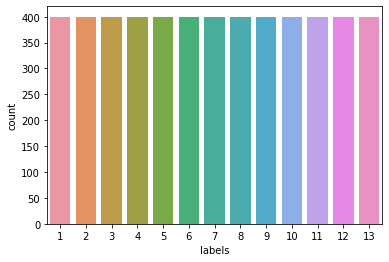

In [65]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)
print(distRos)

Now we have a much more even distriution of sample sizes for each of our 7 ailments (plus an 8th category for other/typos). This should help make our model less biased in favor of the majority class (0=No Finding).

In [59]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [ 1.58440171  0.22679309  1.00067476  2.78236398  2.71611722  3.00202429
  0.56195529  8.14835165  1.75502959  2.28153846  0.79220085 22.81538462
  0.59415064]
New Class Weights:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [66]:
runCNNconfusion(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,6,1)

NameError: ignored

In [0]:
vgg16network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,15)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

In [64]:
vgg19network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,15)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

ValueError: ignored

In [0]:
xceptionnetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

In [0]:
resnetnetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

In [0]:
inceptionV3network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

In [0]:
xceptionnetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

In [0]:
mobilenetnetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

In [0]:
densenet169network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

In [0]:
densenet121network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,14,5)

**Resize **

In [26]:
import cv2
import os
import time


def create_directory(directory):
    """
    Creates a new folder in the specified directory if folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def crop_and_resize_images(path, new_path, img_size):
    """
    Crops, resizes, and stores all images from a directory in a new directory.
    INPUT
        path: Path where the current, unscaled images are contained.
        new_path: Path to save the resized images.
        img_size: New size for the rescaled images.
    OUTPUT
        All images cropped, resized, and saved to the new folder.
    """
    create_directory(new_path)
    dirs = [l for l in os.listdir(path) if l != '.DS_Store']
    # total = 0

    for item in dirs:
        # Read in all images as grayscale
        img = cv2.imread(path + item, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        cv2.imwrite(str(new_path + item), img)
        # total += 1
        # print("Saving: ", item, total)


if __name__ == '__main__':
    start_time = time.time()
    crop_and_resize_images(path='/content/input/images_001/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_002/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_003/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_004/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_005/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_006/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_007/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_008/images/', new_path='/content/input/resized-256/', img_size=256)
  #  crop_and_resize_images(path='/content/input/images_009/images/', new_path='/content/input/resized-256/', img_size=256)
   # crop_and_resize_images(path='/content/input/images_010/images/', new_path='/content/input/resized-256/', img_size=256)
 #   crop_and_resize_images(path='/content/input/images_011/images/', new_path='/content/input/resized-256/', img_size=256)
 #   crop_and_resize_images(path='/content/input/images_012/images/', new_path='/content/input/resized-256/', img_size=256)
   
    print("Seconds: ", time.time() - start_time)

FileNotFoundError: ignored

**reconcile_label**

In [0]:
import os

import pandas as pd


def get_lst_images(file_path):
    """
    Reads in all files from file path into a list.
    INPUT
        file_path: specified file path containing the images.
    OUTPUT
        List of image strings
    """
    return [i for i in os.listdir(file_path) if i != '.DS_Store']


if __name__ == '__main__':
    data = pd.read_csv("/content/input/Data_Entry_2017.csv")
    sample = os.listdir('/content/input/resized-256/')

    sample = pd.DataFrame({'Image Index': sample})

    sample = pd.merge(sample, data, how='left', on='Image Index')

    sample.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                      'Patient_Age', 'Patient_Gender', 'View_Position',
                      'Original_Image_Width', 'Original_Image_Height',
                      'Original_Image_Pixel_Spacing_X',
                      'Original_Image_Pixel_Spacing_Y', 'Unnamed']

    sample['Finding_Labels'] = sample['Finding_Labels'].apply(lambda x: x.split('|')[0])

    sample.drop(['Original_Image_Pixel_Spacing_X', 'Original_Image_Pixel_Spacing_Y', 'Unnamed'], axis=1, inplace=True)
    sample.drop(['Original_Image_Width', 'Original_Image_Height'], axis=1, inplace=True)

    print("Writing CSV")
    sample.to_csv('/content/input/sample_labels.csv', index=False, header=True)

**Images to Array**

In [0]:
import time

import cv2
import numpy as np
import pandas as pd


def convert_images_to_arrays(file_path, df):
    """
    Converts each image to an array, and appends each array to a new NumPy
    array, based on the image column equaling the image file name.
    INPUT
        file_path: Specified file path for resized test and train images.
        df: Pandas DataFrame being used to assist file imports.
    OUTPUT
        NumPy array of image arrays.
    """

    lst_imgs = [l for l in df['Image_Index']]

    return np.array([np.array(cv2.imread(file_path + img, cv2.IMREAD_GRAYSCALE)) for img in lst_imgs])


def save_to_array(arr_name, arr_object):
    """
    Saves data object as a NumPy file. Used for saving train and test arrays.
    INPUT
        arr_name: The name of the file you want to save.
            This input takes a directory string.
        arr_object: NumPy array of arrays. This object is saved as a NumPy file.
    """
    return np.save(arr_name, arr_object)


if __name__ == '__main__':
    start_time = time.time()

    labels = pd.read_csv("/content/input/sample_labels.csv")

    print("Writing Train Array")
    X_train = convert_images_to_arrays('/content/input/resized-256/', labels)

    print(X_train.shape)

    print("Saving Train Array")
    save_to_array('/content/input/X_sample.npy', X_train)

    print("Seconds: ", round(time.time() - start_time), 2)

**Model**

In [0]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(X, y, test_data_size):
    '''
    Split data into test and training datasets.
    INPUT
        X: NumPy array of arrays
        y: Pandas series, which are the labels for input array X
        test_data_size: size of test/train split. Value from 0 to 1
    OUPUT
        Four arrays: X_train, X_test, y_train, and y_test
    '''
    return train_test_split(X, y, test_size=test_data_size, random_state=42)


def reshape_data(arr, img_rows, img_cols, channels):
    '''
    Reshapes the data into format for CNN.
    INPUT
        arr: Array of NumPy arrays.
        img_rows: Image height
        img_cols: Image width
        channels: Specify if the image is grayscale (1) or RGB (3)
    OUTPUT
        Reshaped array of NumPy arrays.
    '''
    return arr.reshape(arr.shape[0], img_rows, img_cols, channels)

def cnn_model(X_train, y_train, kernel_size, nb_filters, channels, nb_epoch, batch_size, nb_classes):
    '''
    Define and run the Convolutional Neural Network
    INPUT
        X_train: Array of NumPy arrays
        X_test: Array of NumPy arrays
        y_train: Array of labels
        y_test: Array of labels
        kernel_size: Initial size of kernel
        nb_filters: Initial number of filters
        channels: Specify if the image is grayscale (1) or RGB (3)
        nb_epoch: Number of epochs
        batch_size: Batch size for the model
        nb_classes: Number of classes for classification
    OUTPUT
        Fitted CNN model
    '''

    model = Sequential()

    '''
    First set of three layers
    Image size: 256 x 256
    nb_filters = 32
    kernel_size = (2,2)
    '''

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1]),
                     padding='valid',
                     strides=1,
                     input_shape=(img_rows, img_cols, channels)))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    '''
    Second set of three layers
    Image Size: 128 x 128
    nb_filters = 64
    kernel_size = 4,4
    '''

    nb_filters = 64
    kernel_size = (4, 4)

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    model.add(Activation('relu'))

    # model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    # model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    '''
    Third set of three layers
    Image Size: 64 x 64
    nb_filters = 128
    kernel_size = 8,8
    '''

    nb_filters = 128
    kernel_size = (8, 8)

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    model.add(Activation('relu'))

    model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    model.add(Activation('relu'))

    # model.add(Conv2D(nb_filters, (kernel_size[0], kernel_size[1])))
    # model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(12, 12)))

    model.add(Flatten())
    print("Model flattened out to: ", model.output_shape)

    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(4096))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    #model = multi_gpu_model(model)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print(model.summary())

    stop = EarlyStopping(monitor='acc',
                         min_delta=0.001,
                         patience=2,
                         verbose=0,
                         mode='auto')

    tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
              verbose=1,
              validation_split=0.2,
              class_weight='auto',
              callbacks=[stop, tensor_board]
              )
    return model

if __name__ == '__main__':

    batch_size = 100
    nb_classes = 15
    nb_epoch = 20
    #nb_gpus = 2
    img_rows, img_cols = 256,256
    channels = 1
    nb_filters = 32
    kernel_size = (2, 2)

    # Import data
    labels = pd.read_csv("/content/input/sample_labels.csv")
    X = np.load("/content/input/X_sample.npy")

    y = labels.Finding_Labels
    # y = np.array(pd.get_dummies(y))
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = y.reshape(-1, 1)

    print("Splitting data into test/ train datasets")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    print("Reshaping Data")
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)

    print("X_train Shape: ", X_train.shape)
    print("X_test Shape: ", X_test.shape)

    input_shape = (img_rows, img_cols, channels)

    print("Normalizing Data")
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    print("y_train Shape: ", y_train.shape)
    print("y_test Shape: ", y_test.shape)


    model = cnn_model(X_train, y_train, kernel_size, nb_filters, channels, nb_epoch, batch_size, nb_classes)

    print("Predicting")
    y_pred = model.predict(X_test)

    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average="weighted")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)